<a href="https://colab.research.google.com/github/yassikazem/IAAC---AI-/blob/main/quickstarts/03_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/03_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

In [1]:
!pip install osmnx geopy scikit-learn ortools ipykernel plotly nbformat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!

In [2]:
# !pip install --upgrade nbformat

* [Ortools package](https://developers.google.com/optimization)
* [What is optimization](https://en.wikipedia.org/wiki/Mathematical_optimization)
* [Video on what optimization is](https://youtu.be/AM6BY4btj-M?t=170&si=FUAW-bzml27y61zq) - only 2.50 - 6.00

## 🕍Optimizing house placement

In [77]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

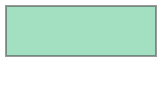

In [76]:
width = 150
depth = 50
x1 = 0
y1 = 0
coords = [(x1, y1), (x1 + width, y1), (x1+width, y1+depth), (x1, y1+depth), (x1, y1)]
house = Polygon(coords)
house

Site geometry

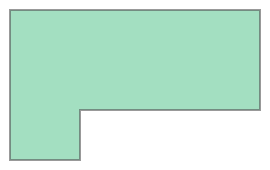

In [75]:
coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site = Polygon(coords)
site

### Optimizing house position

We will be using [CP-SAT](https://developers.google.com/optimization/cp/cp_solver) solver made available to general public by Google.

In [6]:
from ortools.sat.python import cp_model
model = cp_model.CpModel()

Let's place our house onto the site. The constraints would be that:
* all house coordinates are within the site polygon

In [78]:
site.bounds

(0.0, 0.0, 250.0, 150.0)

In [79]:
# Int var says that we create an integer variable that can have any value in a certain range.
# This range is given when we define the variable: here it is 0 and the maximum coordinate of our site (250):
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')  # last argument is the name of the variable in the model
x1

x1(0..250)

In [80]:
# The rest of the house coordinates
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')
y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')
y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')

Now let's add the relationship between the coordinates and tell our model that x2 - x1 = width

In [81]:
model.Add(x2-x1==width)
model.Add(y2-y1==depth)

# Note that our house does not rotate at the moment. We are only placing it vertically.

In [82]:
model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [83]:
model.Minimize(y2)

In [84]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [85]:
print("x1:", solver.Value(x1))
print("x2:", solver.Value(x2))
print("y1:", solver.Value(y1))
print("y2:", solver.Value(y2))

x1: 0
x2: 150
y1: 0
y2: 50


In [86]:
house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

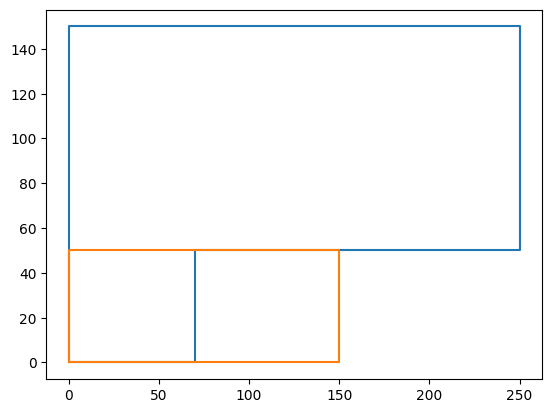

In [87]:
plt.plot(*site.exterior.xy)
plt.plot(*house_location.exterior.xy)

In [89]:
def plot_result(slvr):
    print("x1:", slvr.Value(x1))
    print("x2:", slvr.Value(x2))
    print("y1:", slvr.Value(y1))
    print("y2:", slvr.Value(y2))

    house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

    plt.plot(*site.exterior.xy)
    plt.plot(*house_location.exterior.xy)


Let's adjust our constraints:

In [90]:
model = cp_model.CpModel()
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')
y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')
y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')

model.Add(x2-x1==width)
model.Add(y2-y1==depth)

model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [91]:
x1_outside = model.NewBoolVar("x1_outside")  # true if x1 > 70 -> in the question zone
x2_outside = model.NewBoolVar("x2_outside")  # true if x2 > 70 -> in the question zone

In [92]:
model.Add(x1>=70).OnlyEnforceIf(x1_outside)
model.Add(x1<70).OnlyEnforceIf(x1_outside.Not())
model.Add(x2>=70).OnlyEnforceIf(x2_outside)
model.Add(x2<70).OnlyEnforceIf(x2_outside.Not())

In [93]:
model.Add(y1>=50).OnlyEnforceIf(x1_outside)  # if x coordinate is in the "outside zone" y coordinate can only be from 50 to 150
model.Add(y1>=50).OnlyEnforceIf(x2_outside)
model.Add(y2>=50).OnlyEnforceIf(x1_outside)
model.Add(y2>=50).OnlyEnforceIf(x2_outside)

In [94]:
model.Minimize(y2)
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [95]:
solver.status_name()

'OPTIMAL'

x1: 69
x2: 219
y1: 50
y2: 100


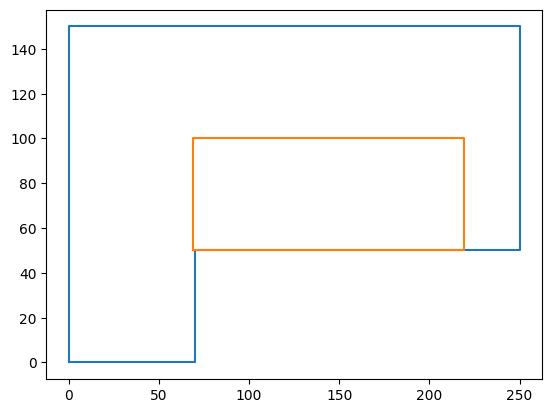

In [96]:
plot_result(solver)

### 🧩 Task I - multiple houses

We learnt how to place a single house on a given site. Let's say we have multiple houses and our goal is to fit as many as possible on a site.

Assume that there are no regulations on distance between the houses.

__Hint:__
* take a look at [2d bin packing](https://yetanothermathprogrammingconsultant.blogspot.com/2021/02/2d-bin-packing-with-google-or-tools-cp.html), feel free to adjust the code
* use [interval var](https://developers.google.com/optimization/reference/python/sat/python/cp_model#newintervalvar)
* use [AddNoOverlap2D](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addnooverlap2d)

In [97]:
# site_coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site_coords = [(0,0), (200, 0), (200, 400), (0, 400), (0,0)]  # simplified version

In [98]:
# houses are presented as width and height
houses = [
    [20, 40],
    [25, 40],
    [70, 100],
    [75, 30],
    [30, 30],
    [30, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
]

To get you started, we initiate the model and add a variable for each house that shows whether it is placed or not:

In [99]:
a = [True, False, True, True, False,]
sum(a)

3

In [100]:
model = cp_model.CpModel()
placed_vars = []

for house in range(len(houses)):
    placed_vars.append(model.NewBoolVar("placed_{}".format(house)))

# take a look at it:
placed_vars[0]

placed_0(0..1)

Building variables for one house (let's take number 1):

![Variables explanation](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/1.jpg?raw=1)

In [101]:
a = []

In [102]:
a

[]

In [103]:
a.append(12)

In [104]:
MAX_SITE_WIDTH = max([s[0] for s in site_coords])
MAX_SITE_HEIGHT = max([s[1] for s in site_coords])

x1 = []
x2 = []
y1 = []
y2 = []

for house_number in range(len(houses)):

  x1.append(model.NewIntVar(0,  MAX_SITE_WIDTH, 'x1_{}'.format(house_number)))
  x2.append(model.NewIntVar(0,  MAX_SITE_WIDTH, 'x2_{}'.format(house_number)))
  y1.append(model.NewIntVar(0,  MAX_SITE_HEIGHT, 'y1_{}'.format(house_number)))
  y2.append(model.NewIntVar(0,  MAX_SITE_HEIGHT, 'y2_{}'.format(house_number)))


In [105]:
# interval variables
# Arguments: start, size, end, whether it is placed, variable name
# https://developers.google.com/optimization/reference/python/sat/python/cp_model#newoptionalintervalvar

house_number = 1
width_interval = model.NewOptionalIntervalVar(x1[house_number], houses[house_number][0], x2[house_number],
                                              placed_vars[house_number],
                                              'width_interval_{}'.format(house_number))

depth_interval = model.NewOptionalIntervalVar(y1[house_number], houses[house_number][1], y2[house_number],
                                              placed_vars[house_number],
                                              'depth_interval_{}'.format(house_number))

Complete the model with all the houses.

In [106]:
# your code here
house_width_intervals = []
house_depth_intervals = []

for house_number in range(len(houses)):
  house_width_intervals.append(model.NewOptionalIntervalVar(x1[house_number], houses[house_number][0], x2[house_number], placed_vars[house_number], 'width_interval_{}'.format(house_number)))
  house_depth_intervals.append(model.NewOptionalIntervalVar(y1[house_number], houses[house_number][1], y2[house_number], placed_vars[house_number], 'depth_interval_{}'.format(house_number)))

house_width_intervals
house_depth_intervals


[depth_interval_0(start = y1_0, size = 40, end = y2_0, is_present = placed_0),
 depth_interval_1(start = y1_1, size = 40, end = y2_1, is_present = placed_1),
 depth_interval_2(start = y1_2, size = 100, end = y2_2, is_present = placed_2),
 depth_interval_3(start = y1_3, size = 30, end = y2_3, is_present = placed_3),
 depth_interval_4(start = y1_4, size = 30, end = y2_4, is_present = placed_4),
 depth_interval_5(start = y1_5, size = 30, end = y2_5, is_present = placed_5),
 depth_interval_6(start = y1_6, size = 25, end = y2_6, is_present = placed_6),
 depth_interval_7(start = y1_7, size = 20, end = y2_7, is_present = placed_7),
 depth_interval_8(start = y1_8, size = 20, end = y2_8, is_present = placed_8),
 depth_interval_9(start = y1_9, size = 30, end = y2_9, is_present = placed_9),
 depth_interval_10(start = y1_10, size = 30, end = y2_10, is_present = placed_10),
 depth_interval_11(start = y1_11, size = 25, end = y2_11, is_present = placed_11),
 depth_interval_12(start = y1_12, size = 20

![Overlap](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/2.jpg?raw=1)

In [117]:
model.AddNoOverlap2D(house_width_intervals, house_depth_intervals)

Run the solver and visualize the solution

In [108]:
# your code here

# objective
model.Maximize(sum(placed_vars))

# solve model
solver = cp_model.CpSolver()
status = solver.Solve(model)
status



4

In [111]:
solver.status_name()

'OPTIMAL'

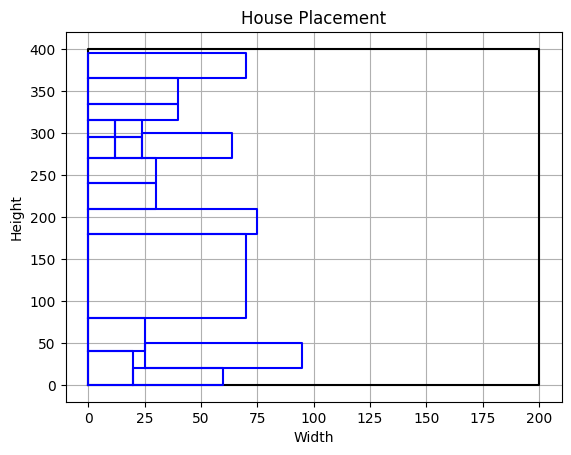

In [113]:
import matplotlib.pyplot as plt

# Extracting the solution
solution = [(solver.Value(x1[i]), solver.Value(y1[i]), solver.Value(x2[i]), solver.Value(y2[i])) for i in range(len(houses))]

# Plotting the site outline
plt.plot([coord[0] for coord in site_coords], [coord[1] for coord in site_coords], 'k-')

# Plotting the houses
for house_coords in solution:
    x1, y1, x2, y2 = house_coords
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('House Placement')
plt.grid(True)
plt.show()


### 🧩 Task II - adding the roads

Our houses are placed in a dense grid. Add roads, bike lanes and walkways as constraints to our model

In [ ]:
# your code here